In [72]:
import torch
import pickle
from torch import nn,optim
import torch.nn.functional
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os as os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,multilabel_confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from scipy.stats import kurtosis,skew
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
import scipy.stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel, f_classif
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import cross_val_score
from collections import OrderedDict

#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)


In [73]:
path_dataframes="/Users/alexdediu/git-projects/Data-Challenge-PHM-Asia-Pacific-2023/dataframes"


In [74]:
with open('dfs_test_list.pkl', 'rb') as file:
    dfs_test = pickle.load(file)

with open('dfs_train_list.pkl', 'rb') as file:
    dfs_train = pickle.load(file)

# Analisi spettrale.
calcolo FFT per ogni serie temporale (P1-P7) di ogni caso (1-177)

eliminazione della frequenza 0 (componente DC).

fftfreq calcola le frequenze associate ai coefficienti ottenuti dalla fft.

il plot seguente ha sull'asse x le frequenze e sull'asse y la fft.

per la ftt basta la parte reale o bisogna mantenere anche la fase (parte immaginaria)?


In [75]:
sampling_rate = 1000  # 1 kHz
signal_length_ms = 1200

In [76]:
def calculate_spectral_features(freqs,spectrum):

    signal_power = np.sum(spectrum)
    noise_power = np.sum(spectrum[freqs > 0.5 * sampling_rate])
    distortion_power = signal_power - noise_power 

    epsilon = 1e-10
    snr = 10 * np.log10(signal_power / (noise_power + epsilon))

    sinad = 10 * np.log10(signal_power / (noise_power + distortion_power + epsilon))

    # peak_amplitude = np.max(time_series)

    band_power = np.sum(spectrum[(freqs >= 0) & (freqs <= max(range(len(freqs))))])

    peak_value = np.max(spectrum)

    peak_freq = freqs[np.argmax(spectrum)]

    mean_power_spectrum = np.mean(spectrum)
   

    sum_power_spectrum = np.sum(spectrum)
    std_spectrum = np.std(spectrum)

    return sinad, snr, band_power, peak_value, peak_freq, mean_power_spectrum, sum_power_spectrum,std_spectrum

def calculate_additional_spectral_features(freqs,spectrum):
    

    harmonic_amplitude_ratio = np.max(spectrum) / np.mean(spectrum)
    main_harmonic_bandwidth = freqs[np.argmax(spectrum)] - freqs[np.argmin(spectrum)]


    return harmonic_amplitude_ratio, main_harmonic_bandwidth

In [77]:
def spectral_features(dfs_data):
    dfs_freq = []
    dfs_fft = []
    freq_dom = []

    for df in dfs_data:
        fft_df = pd.DataFrame()
        # fft_freq = pd.DataFrame()
        freq_dom_col = pd.DataFrame()

        for col in df.columns:
            if  (col != "TIME") and (col != "Case"):
                fft_result = np.fft.fft(df[col]).real
                freq = np.fft.fftfreq(len(df[col]), d=1/sampling_rate)

                # eliminazione componente DC
                fft_result = fft_result[1:]
                freq = freq[1:]

                # spettro di potenza
                power_spectrum = np.abs(fft_result) ** 2

                # calcolo features spettrali
                sinad, snr, band_power, peak_value, peak_freq, mean_power_spectrum, sum_power_spectrum,std_spectrum = calculate_spectral_features(freq,power_spectrum)
                harmonic_amplitude_ratio, main_harmonic_bandwidth = calculate_additional_spectral_features(freq,power_spectrum)


                max_val = np.max(np.abs(fft_result))
                
                # da spostare nelle features temporali
                impulse_factor = max_val / np.mean(np.abs(df[col]))
                crest_factor = max_val / np.sqrt(np.mean(np.square(df[col])))
                # freq_dom_col["Case_fft"] = [df["Case"].iloc[0]]

                ampl = np.abs(fft_result)
                amplitudes_sum = np.sum(ampl)
                prob_amplitudes = ampl / amplitudes_sum
                entropy = -np.sum(prob_amplitudes * np.log2(prob_amplitudes + 1e-12)) # 1e-12 per evitare log(0)

                squared = np.square(df[col])
                mean_squared = np.mean(squared)
                rms = np.sqrt(mean_squared)
                


                freq_dom_col[col + "_SINAD"] = [sinad]
                freq_dom_col[col + "_rms"] = [rms]
                freq_dom_col[col + "_entropy"] = [entropy]

                freq_dom_col[col + "_SNR"] = [snr]
        
                freq_dom_col[col + "_crest_factor"] = [crest_factor]
                freq_dom_col[col + "_impulse_factor"] = [impulse_factor]
                freq_dom_col[col + "_BandPower"] = [band_power]
                freq_dom_col[col + "_PeakValue"] = [peak_value]
                freq_dom_col[col + "_PeakFreq"] = [peak_freq]
                freq_dom_col[col + "_SumPowerSpectrum"] = [sum_power_spectrum]
                # freq_dom_col[col + "_StdPowerSpectrum"] = [std_spectrum]

                freq_dom_col[col + "_HarmonicAmplitudeRatio"] = [harmonic_amplitude_ratio]
                freq_dom_col[col + "_MainHarmonicBandwidth"] = [main_harmonic_bandwidth]

                fft_df[col + '_fft'] = fft_result
                # for f in freq:
                #     fft_freq[col + '_freq'] = freq
    

        # dfs_freq.append(fft_freq)
        dfs_fft.append(fft_df)
        freq_dom.append(freq_dom_col)

    

    return freq_dom,dfs_fft



In [78]:
dfs_sf_test,dfs_fft_test = spectral_features(dfs_test)
dfs_sf_train,dfs_fft_train= spectral_features(dfs_train)

In [79]:
dfs_sf_test

[       P1_SINAD    P1_rms  P1_entropy      P1_SNR  P1_crest_factor  \
 0 -6.268129e-15  2.007053    8.740551  148.436991        40.156635   
 
    P1_impulse_factor  P1_BandPower  P1_PeakValue  P1_PeakFreq  \
 0          40.614592  34887.443656   6495.792449   -59.950042   
 
    P1_SumPowerSpectrum  ...  P7_entropy      P7_SNR  P7_crest_factor  \
 0         69774.887313  ...    8.596711  153.718815         74.55733   
 
    P7_impulse_factor   P7_BandPower  P7_PeakValue  P7_PeakFreq  \
 0          77.397851  117720.342912  23293.428556   -59.950042   
 
    P7_SumPowerSpectrum  P7_HarmonicAmplitudeRatio  P7_MainHarmonicBandwidth  
 0        235440.685824                 118.722532               -466.278102  
 
 [1 rows x 84 columns],
        P1_SINAD    P1_rms  P1_entropy      P1_SNR  P1_crest_factor  \
 0 -6.750292e-15  2.008349    8.722254  148.279854        39.227758   
 
    P1_impulse_factor  P1_BandPower  P1_PeakValue  P1_PeakFreq  \
 0          39.690545  33647.700676    6206.

In [80]:
def calculate_column_statistics(column):
 
    statistics = {
        'mean': column.mean(),
        'median': column.median(),
        'std': column.std(),
        'min': column.min(),
        'max': column.max(),
        '25th_percentile': column.quantile(0.25),
        '75th_percentile': column.quantile(0.75),
        'kurtosis': kurtosis(column),
        'skewness': skew(column)
    
        # Puoi aggiungere altre statistiche a seconda delle tue esigenze
    }
    return pd.Series(statistics)

In [81]:
def statistics_df(dfs_list):
    dfs = []


    for df in dfs_list:
        statistics_dict = OrderedDict()    
        for col in df.columns:
            
            if (col != "TIME") and (col != "Case"):
                column_stats = calculate_column_statistics(df[col])
          
                line_integral = np.trapz(df[col])
                clearance_factor = np.max(df[col]) - np.min(df[col])

                statistics_dict[col + "_mean"] = column_stats["mean"]
                statistics_dict[col + "_median"] = column_stats["median"]
                statistics_dict[col + "_std"] = column_stats["std"]
                statistics_dict[col + "_min"] = column_stats["min"]
                statistics_dict[col + "_max"] = column_stats["max"]
                statistics_dict[col + "_25th_percentile"] = column_stats["25th_percentile"]
                statistics_dict[col + "_75th_percentile"] = column_stats["75th_percentile"]
                statistics_dict[col + "_kurtosis"] = column_stats["kurtosis"]
                statistics_dict[col + "_skewness"] = column_stats["skewness"]
                statistics_dict[col + "_variance"] = np.var(df[col])
                statistics_dict[col + "_line_integral"] = line_integral
                statistics_dict[col + "_clearance_factor"] = clearance_factor
                # statistics_dict["Case_stats_temp"] = df["Case"].iloc[0]

        statistics_df = pd.DataFrame(statistics_dict,index=[0])
        dfs.append(statistics_df)

    
    return dfs


In [82]:
dfs_stats_temp_train = statistics_df(dfs_train)
dfs_stats_fft_train = statistics_df(dfs_fft_train)
#test
dfs_stats_temp_test = statistics_df(dfs_test)
dfs_stats_fft_test = statistics_df(dfs_fft_test)

In [83]:
dfs_stats_fft_train

[   P1_fft_mean  P1_fft_median  P1_fft_std  P1_fft_min  P1_fft_max  \
 0     0.015146       0.135039    7.515602  -78.106946   71.621197   
 
    P1_fft_25th_percentile  P1_fft_75th_percentile  P1_fft_kurtosis  \
 0                -1.11402                1.174801         47.41948   
 
    P1_fft_skewness  P1_fft_variance  ...  P7_fft_std  P7_fft_min  P7_fft_max  \
 0        -1.825348        56.437197  ...   14.216777 -147.559506  154.581021   
 
    P7_fft_25th_percentile  P7_fft_75th_percentile  P7_fft_kurtosis  \
 0               -1.922643                2.052882        59.131407   
 
    P7_fft_skewness  P7_fft_variance  P7_fft_line_integral  \
 0        -1.012595       201.948322             36.109565   
 
    P7_fft_clearance_factor  
 0               302.140527  
 
 [1 rows x 84 columns],
    P1_fft_mean  P1_fft_median  P1_fft_std  P1_fft_min  P1_fft_max  \
 0     0.015082       0.119478    7.511559  -77.900253   71.237182   
 
    P1_fft_25th_percentile  P1_fft_75th_percentile  

In [84]:
df_stats_temp_train = pd.concat(dfs_stats_temp_train,axis=0)
df_stats_fft_train = pd.concat(dfs_stats_fft_train,axis=0)
df_sf_train = pd.concat(dfs_sf_train,axis=0)

#test
df_stats_temp_test = pd.concat(dfs_stats_temp_test,axis=0)
df_stats_fft_test = pd.concat(dfs_stats_fft_test,axis=0)
df_sf_test = pd.concat(dfs_sf_test,axis=0)




In [85]:
df_stats_temp_train

,P1_mean,P1_median,P1_std,P1_min,P1_max,P1_25th_percentile,P1_75th_percentile,P1_kurtosis,P1_skewness,P1_variance,...,P7_std,P7_min,P7_max,P7_25th_percentile,P7_75th_percentile,P7_kurtosis,P7_skewness,P7_variance,P7_line_integral,P7_clearance_factor
0,1.984867,1.956786,0.308519,0.436248,4.228663,1.893564,2.059497,18.304141,1.636982,0.095105,...,0.573871,-0.003006,5.017115,1.804532,2.139209,7.009600,1.005444,0.329054,2366.012724,5.020121
0,1.984931,1.957459,0.308624,0.436435,4.256737,1.893815,2.058403,18.408793,1.667283,0.095169,...,0.579382,-0.003786,4.999330,1.803312,2.141343,6.530707,0.957497,0.335404,2366.376508,5.003116
0,1.984999,1.960032,0.308539,0.436793,4.295627,1.892870,2.058726,18.574106,1.680704,0.095117,...,0.594715,-0.007141,5.000936,1.798699,2.139498,6.121365,0.999735,0.353392,2368.725329,5.008078
0,1.984965,1.958703,0.308392,0.437050,4.295622,1.893398,2.058818,18.513062,1.659309,0.095026,...,0.567000,-0.002395,5.008294,1.803063,2.137299,7.217882,1.050071,0.321221,2365.701657,5.010689
0,1.984987,1.958311,0.308432,0.437011,4.281213,1.893440,2.059063,18.366902,1.645950,0.095051,...,0.569452,-0.002607,4.998044,1.801804,2.138255,7.084213,1.047163,0.324006,2366.740718,5.000651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.984983,1.956329,0.278327,0.543228,4.016765,1.890819,2.065815,15.468806,1.866904,0.077401,...,0.554805,0.000442,4.918386,1.815840,2.134921,7.835247,0.720218,0.307552,2361.961235,4.917944
0,1.984349,1.965884,0.278177,0.820108,4.063794,1.897594,2.053114,18.672669,2.190264,0.077318,...,0.623007,-0.015324,5.228732,1.743142,2.209793,6.121074,0.679150,0.387815,2363.165121,5.244057
0,1.984209,1.971360,0.274191,0.522027,4.182883,1.894357,2.062763,21.232798,1.749215,0.075118,...,0.589093,0.001778,5.513235,1.806417,2.111299,10.941186,1.571102,0.346742,2364.069197,5.511457
0,1.985246,1.976075,0.271765,0.579673,4.103252,1.895262,2.058983,20.989922,1.990960,0.073795,...,0.589475,0.266158,4.747359,1.806350,2.139188,5.863030,1.154917,0.347191,2371.499487,4.481201


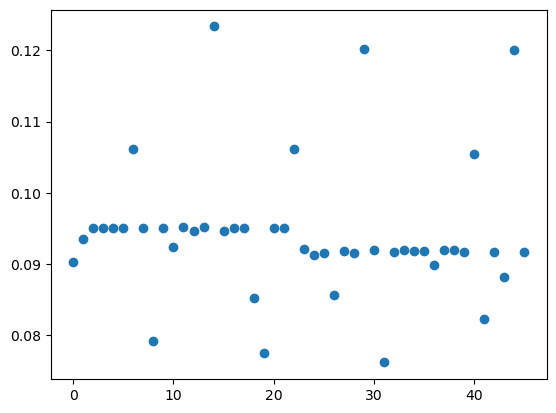

In [86]:
df_stats_temp_test["P2_variance"]
plt.scatter(list(range(len(df_stats_temp_test))),df_stats_temp_test["P1_variance"])

In [87]:
def scaling_df(df, scaler):
    df_stats_scaled = scaler.transform(df)
    df = pd.DataFrame(df_stats_scaled, columns=df.columns)
    return df

# Create separate scalers for each type of data
scaler_temp = MinMaxScaler()
scaler_fft = MinMaxScaler()
scaler_sf = MinMaxScaler()

# Fit the scalers on the training data
scaler_temp.fit(df_stats_temp_train)
scaler_fft.fit(df_stats_fft_train)
scaler_sf.fit(df_sf_train)

# Scale the training data
df_stats_temp_train = scaling_df(df_stats_temp_train, scaler_temp)
df_stats_fft_train = scaling_df(df_stats_fft_train, scaler_fft)
df_sf_train = scaling_df(df_sf_train, scaler_sf)

# Scale the test data using the same scalers
df_stats_temp_test = scaling_df(df_stats_temp_test, scaler_temp)
df_stats_fft_test = scaling_df(df_stats_fft_test, scaler_fft)
df_sf_test = scaling_df(df_sf_test, scaler_sf)

In [88]:
df_stats_temp_test

,P1_mean,P1_median,P1_std,P1_min,P1_max,P1_25th_percentile,P1_75th_percentile,P1_kurtosis,P1_skewness,P1_variance,...,P7_std,P7_min,P7_max,P7_25th_percentile,P7_75th_percentile,P7_kurtosis,P7_skewness,P7_variance,P7_line_integral,P7_clearance_factor
0,0.082119,0.495257,0.899719,0.371555,0.923112,0.188521,0.418134,0.774555,0.755085,0.886305,...,0.359186,0.057270,0.469100,0.607413,0.214772,0.398703,0.520736,0.322713,0.317581,0.469914
1,0.147686,0.193701,0.965394,0.182168,0.600528,0.063933,0.738553,0.469434,0.458853,0.960428,...,0.492324,0.059573,0.562223,0.556326,0.245651,0.416832,0.622854,0.452719,0.327472,0.562473
2,0.152884,0.213351,0.996695,0.152192,0.767194,0.065567,0.475029,0.591421,0.542118,0.996205,...,0.509230,0.052445,0.500018,0.399915,0.415068,0.240401,0.469779,0.469630,0.088054,0.502197
3,0.156664,0.047864,0.996463,0.162786,0.784579,0.061874,0.493017,0.613250,0.572967,0.995939,...,0.518980,0.055686,0.494342,0.445276,0.402197,0.253525,0.520217,0.479423,0.342598,0.495616
4,0.150548,0.185015,0.996230,0.152803,0.775698,0.065674,0.487859,0.585901,0.531035,0.995672,...,0.489727,0.055745,0.497392,0.487430,0.242321,0.318003,0.577750,0.450129,0.336929,0.498653
5,0.142371,0.141254,0.996079,0.152057,0.741710,0.064793,0.478750,0.572821,0.513293,0.995498,...,0.467554,0.060559,0.511408,0.556058,0.231628,0.374559,0.543430,0.428107,0.283785,0.511342
6,127.576711,49.069842,1.215672,1.861598,1.871731,25.221792,63.697667,0.372126,0.077068,1.254651,...,0.479865,2.379473,1.037719,7.609692,8.950544,0.366612,0.493677,0.440315,42.865908,0.393873
7,0.141229,0.095970,0.996862,0.152060,0.736165,0.068747,0.491489,0.570604,0.516818,0.996397,...,0.486337,0.060596,0.506951,0.557067,0.264479,0.351482,0.542209,0.446753,0.337361,0.506871
8,0.052536,0.267645,0.659488,0.307737,0.655742,0.032575,0.818869,0.822629,0.663037,0.626103,...,0.670790,0.061998,0.993372,0.489964,0.070828,0.988469,0.991485,0.635798,0.217366,0.993303
9,0.145077,0.101568,0.997281,0.152046,0.772291,0.065113,0.478699,0.600927,0.538299,0.996878,...,0.448697,0.061286,0.510136,0.554101,0.251152,0.373868,0.535903,0.409500,0.256888,0.509868


In [89]:
df_stats_fft_train = df_stats_fft_train.reset_index(drop=True)
df_stats_temp_train = df_stats_temp_train.reset_index(drop=True)
df_sf_train= df_sf_train.reset_index(drop=True)
#test
df_stats_fft_test = df_stats_fft_test.reset_index(drop=True)
df_stats_temp_test = df_stats_temp_test.reset_index(drop=True)
df_sf_test = df_sf_test.reset_index(drop=True)

In [90]:

df_features_train = pd.concat([df_stats_fft_train,df_stats_temp_train,df_sf_train],axis=1)
df_features_test = pd.concat([df_stats_fft_test,df_stats_temp_test,df_sf_test],axis=1)

In [91]:
def feature_selection_anova(df_X,df_y,n_features):
    X = df_X
    y = df_y['binary_condition']
    
    f_values, p_values = f_classif(X, y)

    results = pd.DataFrame({'Feature': X.columns, 'F_Value': f_values, 'P_Value': p_values})

    results = results.sort_values(by='F_Value', ascending=False)

    top_50_features = results.head(n_features)
    features = top_50_features["Feature"].values
    # features=np.concatenate([features, ["binary_condition"]])

    print(results["Feature"].values)
    return features

In [92]:
df_labels_train = pd.read_csv(f"{path_dataframes}/df_labels_train.csv")
df_labels_test = pd.read_csv(f"{path_dataframes}/df_labels_test.csv")

In [93]:
features_train = feature_selection_anova(df_features_train,df_labels_train,20)
# features_test= feature_selection_anova(df_features_test,df_labels_test,10)

['P1_min' 'P5_HarmonicAmplitudeRatio' 'P5_rms' 'P5_variance' 'P5_std'
 'P1_median' 'P1_clearance_factor' 'P5_min' 'P1_variance' 'P1_std'
 'P1_rms' 'P1_HarmonicAmplitudeRatio' 'P2_75th_percentile' 'P2_variance'
 'P2_rms' 'P2_std' 'P5_25th_percentile' 'P2_min'
 'P6_HarmonicAmplitudeRatio' 'P5_fft_25th_percentile' 'P1_fft_median'
 'P7_kurtosis' 'P3_line_integral' 'P3_fft_mean' 'P3_mean' 'P2_SINAD'
 'P3_fft_line_integral' 'P2_fft_skewness' 'P1_25th_percentile'
 'P1_fft_25th_percentile' 'P2_25th_percentile' 'P7_HarmonicAmplitudeRatio'
 'P5_SINAD' 'P6_kurtosis' 'P2_HarmonicAmplitudeRatio' 'P1_max' 'P7_std'
 'P7_variance' 'P7_25th_percentile' 'P1_fft_75th_percentile'
 'P5_line_integral' 'P5_fft_mean' 'P5_mean' 'P6_PeakValue' 'P1_SINAD'
 'P4_HarmonicAmplitudeRatio' 'P1_fft_kurtosis' 'P7_fft_75th_percentile'
 'P3_HarmonicAmplitudeRatio' 'P1_fft_skewness' 'P1_SNR' 'P6_std'
 'P2_fft_line_integral' 'P1_fft_std' 'P6_crest_factor'
 'P7_fft_line_integral' 'P5_fft_line_integral' 'P3_min' 'P7_rms'
 'P6

In [94]:
features_train

array(['P1_min', 'P5_HarmonicAmplitudeRatio', 'P5_rms', 'P5_variance',
       'P5_std', 'P1_median', 'P1_clearance_factor', 'P5_min',
       'P1_variance', 'P1_std', 'P1_rms', 'P1_HarmonicAmplitudeRatio',
       'P2_75th_percentile', 'P2_variance', 'P2_rms', 'P2_std',
       'P5_25th_percentile', 'P2_min', 'P6_HarmonicAmplitudeRatio',
       'P5_fft_25th_percentile'], dtype=object)

In [95]:
df_features_train = df_features_train[features_train]
df_features_test= df_features_test[features_train]

In [96]:
df_features_train.to_csv(f"{path_dataframes}/df_train.csv",index_label="index")
df_features_test.to_csv(f"{path_dataframes}/df_test.csv",index_label="index")

In [97]:
df_features_train

,P1_min,P5_HarmonicAmplitudeRatio,P5_rms,P5_variance,P5_std,P1_median,P1_clearance_factor,P5_min,P1_variance,P1_std,P1_rms,P1_HarmonicAmplitudeRatio,P2_75th_percentile,P2_variance,P2_rms,P2_std,P5_25th_percentile,P2_min,P6_HarmonicAmplitudeRatio,P5_fft_25th_percentile
0,0.151379,0.404716,0.908139,0.989111,0.990348,0.070910,0.835385,0.002855,0.997566,0.997881,0.957028,0.500515,0.793864,0.742221,0.587077,0.764873,0.173932,0.014342,0.535152,0.113235
1,0.151707,0.386983,0.957102,0.970816,0.974082,0.103330,0.856063,0.002856,0.999072,0.999192,0.970137,0.496295,0.762330,0.741918,0.572730,0.764588,0.177174,0.014171,0.534254,0.159739
2,0.152334,0.385712,0.908687,0.942070,0.948400,0.227248,0.884633,0.002595,0.997855,0.998132,0.979246,0.492228,0.765295,0.752047,0.614115,0.774074,0.180487,0.014027,0.516265,0.047297
3,0.152786,0.384052,0.937148,0.964525,0.968475,0.163223,0.884439,0.002830,0.995734,0.996284,0.969917,0.492075,0.775176,0.751956,0.622608,0.773988,0.181395,0.014103,0.509841,0.081392
4,0.152716,0.382267,0.961120,0.975974,0.978674,0.144362,0.873784,0.003023,0.996313,0.996789,0.974559,0.490276,0.792718,0.745000,0.595336,0.767477,0.194015,0.014159,0.505803,0.088930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.339054,1.000000,0.205255,0.504254,0.536422,0.048881,0.598945,0.005946,0.585004,0.620029,0.245719,1.000000,0.593336,1.000000,1.000000,1.000000,0.259250,0.087961,0.687747,0.361840
173,0.824787,0.697196,0.719323,0.781425,0.801969,0.509144,0.428516,0.880071,0.583065,0.618157,0.138386,0.717433,0.569406,0.647391,0.448477,0.675020,0.221795,0.040686,0.730663,0.504753
174,0.301860,0.438246,0.344787,0.577233,0.608061,0.772911,0.737837,0.592579,0.531799,0.568273,0.024519,0.362797,0.000000,0.576285,0.348801,0.606348,0.218800,0.026831,0.561968,0.464898
175,0.402989,0.000000,0.204130,0.497790,0.530013,1.000000,0.636050,0.440788,0.500953,0.537907,0.139861,0.000000,0.127847,0.569685,0.239404,0.599916,0.219502,0.024886,0.000000,0.355554


In [98]:
df_features_test

,P1_min,P5_HarmonicAmplitudeRatio,P5_rms,P5_variance,P5_std,P1_median,P1_clearance_factor,P5_min,P1_variance,P1_std,P1_rms,P1_HarmonicAmplitudeRatio,P2_75th_percentile,P2_variance,P2_rms,P2_std,P5_25th_percentile,P2_min,P6_HarmonicAmplitudeRatio,P5_fft_25th_percentile
0,0.371555,0.529602,0.538355,0.741722,0.764978,0.495257,0.878211,0.048438,0.886305,0.899719,0.687403,0.534043,0.720100,0.808836,0.740012,0.826867,0.251141,0.892153,0.671782,0.261748
1,0.182168,0.428010,0.980064,0.987083,0.988548,0.193701,0.729427,0.003761,0.960428,0.965394,0.902002,0.524429,0.797330,0.679828,0.676689,0.705973,0.174802,0.007976,0.588214,0.018881
2,0.152192,0.390038,0.866643,0.944461,0.950542,0.213351,0.860323,0.002697,0.996205,0.996695,0.971885,0.493879,0.774637,0.748999,0.603978,0.771222,0.176327,0.014128,0.488320,0.092590
3,0.162786,0.396816,0.930225,0.928183,0.935939,0.047864,0.868178,0.018448,0.995939,0.996463,0.976223,0.494610,0.775503,0.750242,0.608319,0.772385,0.169909,0.014086,0.519924,0.277822
4,0.152803,0.385249,0.876601,0.949895,0.955406,0.185015,0.866098,0.002987,0.995672,0.996230,0.967969,0.491803,0.797857,0.748780,0.609360,0.771016,0.179430,0.014132,0.500204,0.072621
5,0.152057,0.397708,0.945323,0.991257,0.992252,0.141254,0.842303,0.003052,0.995498,0.996079,0.957257,0.497038,0.812310,0.743828,0.598078,0.766379,0.176327,0.014342,0.529874,0.097282
6,1.861598,0.472094,67.564014,1.022777,1.020122,49.069842,0.921347,1.884693,1.254651,1.215672,164.065211,0.443278,27.936155,0.797862,71.296628,0.816715,15.878233,1.726244,0.631157,1.064636
7,0.152060,0.393583,0.961413,0.989302,0.990517,0.095970,0.838368,0.002945,0.996397,0.996862,0.957394,0.497270,0.806887,0.743704,0.594304,0.766263,0.179970,0.014342,0.490255,0.106210
8,0.307737,0.621510,0.682774,0.787317,0.807430,0.267645,0.715520,0.592579,0.626103,0.659488,0.188886,0.519669,0.477301,0.430374,0.135904,0.461677,0.200950,0.036904,0.847797,0.153762
9,0.152046,0.390251,0.967401,0.977235,0.979796,0.101568,0.864000,0.002757,0.996878,0.997281,0.963139,0.497029,0.750884,0.748523,0.607860,0.770776,0.179866,0.014222,0.523654,0.172454
